# Extended Analysis of PBSB Artwork Data
An exercise in some more advanced data analysis against my own datasets. Data wrangling performed in the basic and advanced analysis is repeated here with minimal explanation. Some additional pre-processing of the input data was done in Excel.
Theis dataset uses data at the order line level of detail which gives better visibility into individual pieces of art.

## Import libraries

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

# Machine learning and logistic regression libraries
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


## Import Excel file

In [100]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = 'C:\\Users\\simon\\OneDrive\\Documents\\Data Analysis\\Art\\Artwork-Items.xlsx'

# Load the dataset into a DataFrame
df = pd.read_excel('OneDrive/Documents/Data Analysis/Art/Artwork-Items.xlsx')

# Display the first few rows to ensure it loaded correctly
df.head()

,CustomerID,ServiceType,Medium,SaleDate,PromisedBy,OrderCompletionDate,ItemCompletedDate,Frame,Size,ActualTime,Price
0,1,Commission,Pastel on Canson Mi-Teintes,2003-08-06,2003-08-22,2003-08-15,2003-08-15,Unframed,16x22,22,800.0
1,2,Commission,Pen & Ink/Watercolor on Arches 140lb NOT,2003-08-07,2003-08-15,2003-08-10,2003-08-10,NaN,11x14,8,150.0
2,6,Commission,Pen & Ink / Watercolor on Arches 140lb NOT,2003-05-01,NaT,2003-05-31,2003-05-31,NaN,NaN,6,160.0
3,7,Commission,Graphite on Arches 140lb hot press,2003-03-01,NaT,2003-03-31,2003-03-31,NaN,18x24,25,1000.0
4,8,Commission,Graphite on Arches 140lb hot press,2003-04-01,2003-04-15,2003-04-15,2003-04-15,NaN,11x14,16,0.0


## Basic Data Cleanup
Unlike the price data used in previous analyses, the item price data is already formatted as a number and doesn't need further manipulation. There are still some rows with missing values which must be removed.

In [101]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['SaleDate'])

In [102]:
# Filter out rows with 'Price' == 0 or 'ActualTime' == 0
df = df[(df['Price'] > 0) & (df['ActualTime'] > 0)]

In [103]:
# Filter out any records which dont have 'ServiceType' == 'Commission' or 'ServiceType' == 'Artwork sale'
df = df[(df['ServiceType'] == 'Commission') | (df['ServiceType'] == 'Artwork sale')] 

In [104]:
df.head()

,CustomerID,ServiceType,Medium,SaleDate,PromisedBy,OrderCompletionDate,ItemCompletedDate,Frame,Size,ActualTime,Price
0,1,Commission,Pastel on Canson Mi-Teintes,2003-08-06,2003-08-22,2003-08-15,2003-08-15,Unframed,16x22,22,800.0
1,2,Commission,Pen & Ink/Watercolor on Arches 140lb NOT,2003-08-07,2003-08-15,2003-08-10,2003-08-10,NaN,11x14,8,150.0
2,6,Commission,Pen & Ink / Watercolor on Arches 140lb NOT,2003-05-01,NaT,2003-05-31,2003-05-31,NaN,NaN,6,160.0
3,7,Commission,Graphite on Arches 140lb hot press,2003-03-01,NaT,2003-03-31,2003-03-31,NaN,18x24,25,1000.0
6,12,Commission,Graphite on Fabriano 140lb Hot Press,2003-09-06,2003-10-10,2003-09-25,2003-09-25,NaN,Custom,24,650.0


## Data Transformation
### Price Outliers and Normalization
Assess the price data for outliers using min-max normalization.

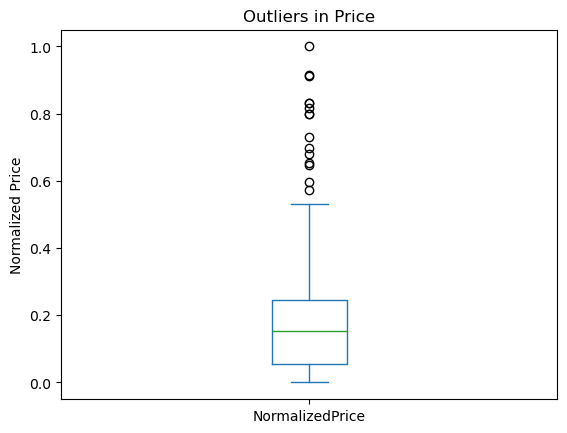

In [105]:
# Use min-max normalization

# Calc mean and std deviation of painting prices
min_price = df['Price'].min()
max_price = df['Price'].max()

# Normalize
df['NormalizedPrice'] = (df['Price'] - min_price) / (max_price - min_price)

# Visualize distribution of ConvertedCompYearly using a box plot
df['NormalizedPrice'].plot(kind='box')
plt.title('Outliers in Price')
plt.xlabel('')
plt.ylabel('Normalized Price')

# Save the plot as a PNG file
plt.savefig('outliers_box.png', format='png', dpi=300)

plt.show()

Since there are no obvious major outliers, we don't need to remove any outliers from the price data.

### Extract 'Year'
Since the SaleDate column is already in date/time format, the Year can be extracted directly.

In [106]:
# Create a Year column
df['Year'] = df['SaleDate'].dt.year.astype(int)

### Calculate 'Area' for each item where possible
Use data in the 'Size' column to calculate the area of each painting in square incheas.

In [107]:
# Function to calculate area from 'Size' column
def calculate_area(size):
    if pd.isna(size):
        return None  
    try:
        # Convert the value to a string
        size_str = str(size)
        # Use regular expression to find the first pair of numbers (including decimals)
        match = re.search(r'(\d+(\.\d+)?)\s*x\s*(\d+(\.\d+)?)', size_str)
        if match:
            height, width = map(float, match.groups()[::2])  # Extract only the numeric parts
            return height * width
        else:
            return None  # Handle cases where the size format is incorrect
    except ValueError:
        return None  # Handle cases where the size format is incorrect

# Apply the function to the 'Size' column and create a new 'Area' column
df['Area'] = df['Size'].apply(calculate_area)

# Display the DataFrame with the new 'Area' column
print(df['Area'].head())



0    352.0
1    154.0
2      NaN
3    432.0
6      NaN
Name: Area, dtype: float64


### Remove records missing 'Area'

In [108]:
# Drop any records that don't have a useable 'Area'
df = df.dropna(subset=['Area'])

### Look for Outliers in Area

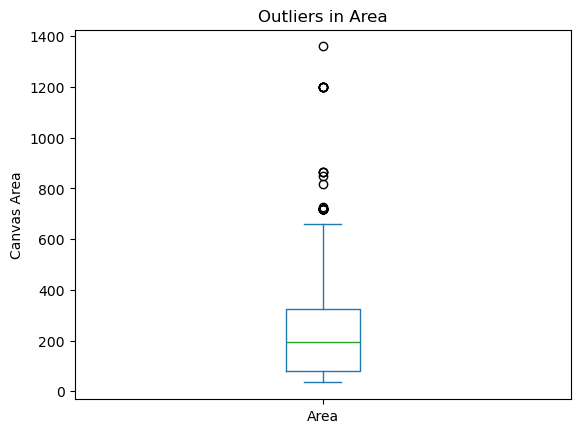

In [109]:
# Visualize distribution of ConvertedCompYearly using a box plot
df['Area'].plot(kind='box')
plt.title('Outliers in Area')
plt.xlabel('')
plt.ylabel('Canvas Area')

# Save the plot as a PNG file
plt.savefig('outliers_area.png', format='png', dpi=300)

plt.show()

## Pricing Analysis
### How Consistent Are the Prices?
Let's look at earnings per unit time spent creating each piece. We'll treat Commissions and Retail Artwork because they have different service characteristics. Which type of art is the most profitable?

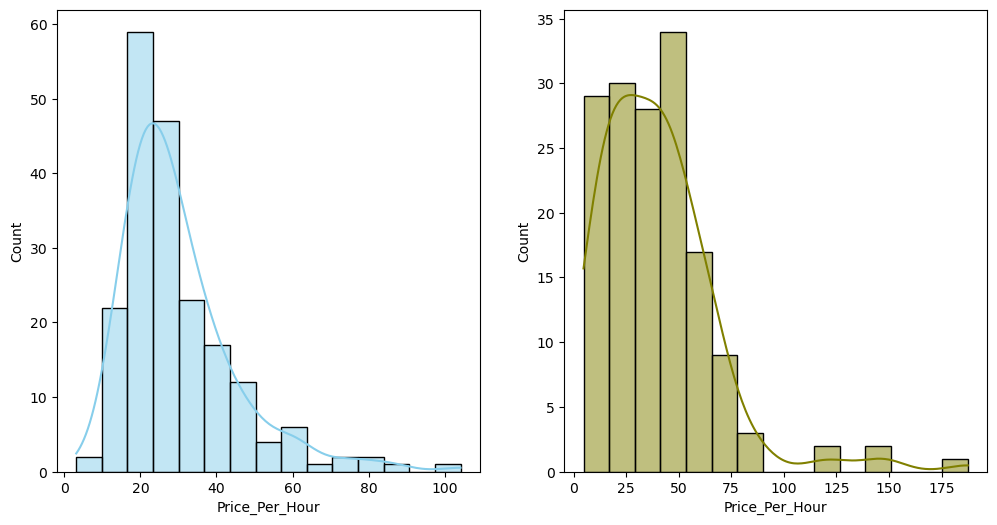

In [110]:
df['Price_Per_Hour'] = df['Price']/df['ActualTime']

df_commission = df[df['ServiceType']=='Commission']
df_retail = df[df['ServiceType']=='Artwork sale']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_commission, x='Price_Per_Hour', bins=15, kde=True, color='skyblue', ax=axs[0])
sns.histplot(data=df_retail, x='Price_Per_Hour', bins=15, kde=True, color='olive', ax=axs[1])

plt.show()

### Is Pricing Consistent With the Painting Size?

In [111]:
df['Price_Per_Area'] = df['Price']/df['Area']
df_commission = df[df['ServiceType']=='Commission']
df_retail = df[df['ServiceType']=='Artwork sale']

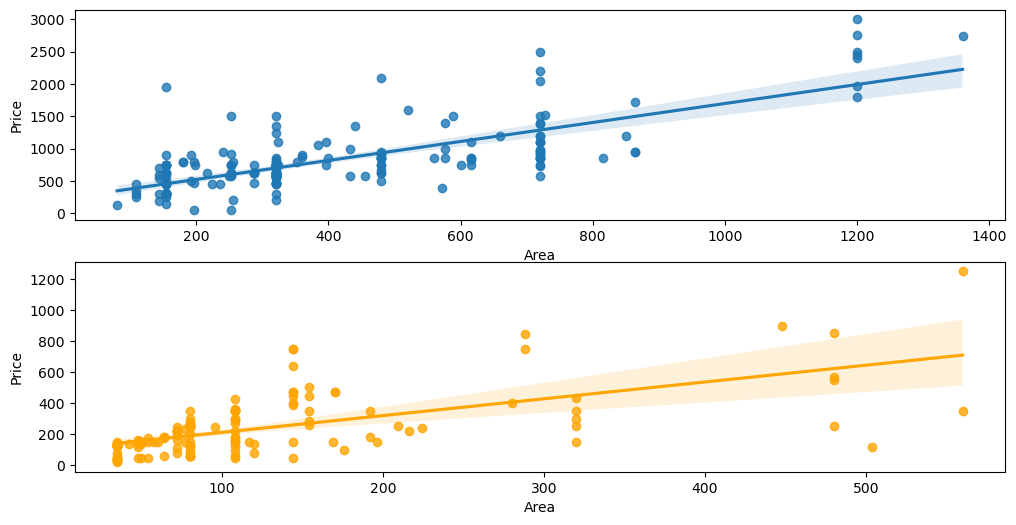

In [112]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

sns.regplot(
    x='Area',
    y='Price',
    data=df_commission,
    ax=axs[0]
)

sns.regplot(
    x='Area',
    y='Price',
    data=df_retail,
    color = 'orange',
    ax=axs[1]
)
            
plt.show()


Working in standard sizes, such as 9in x 12in or 20in x 24in creates clustered vertical lines in the plots. The regression lines seem to indicate that commissioned paintings are more profitable in terms of price per unit canvas size than retail artwork, but is that really the case? 

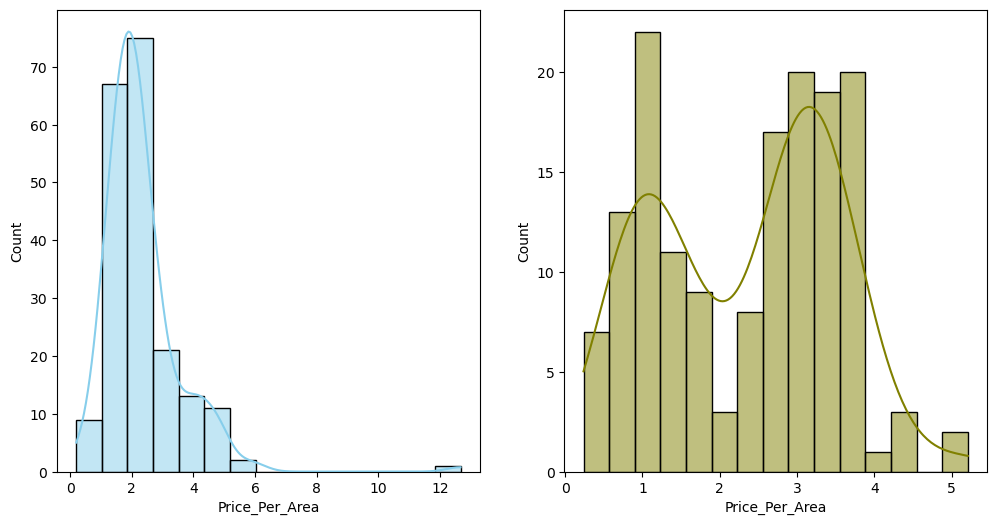

In [113]:
# Create side-by-side histograms of price per area
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_commission, x='Price_Per_Area', bins=15, kde=True, color='skyblue', ax=axs[0])
sns.histplot(data=df_retail, x='Price_Per_Area', bins=15, kde=True, color='olive', ax=axs[1])

plt.show()

We can see that the distribution of price per area for commissioned portraits is well grouped. For retail artwork, there are two distinct groupings which can largely be explained by having framed vs. unframed paintings. Commissioned paintings are always sold unframed.
For framed retail artwork, the price by unit canvas size is actually about 50% greater than that for commissioned paintings.

### Price Effect of Framing
To assess the effect framing on retail artwork, first let's look at whether or not we keep good records.

      Frame  Count
0       NaN     90
1    Framed     54
2  Unframed     11
Total count including blanks or null values: 354


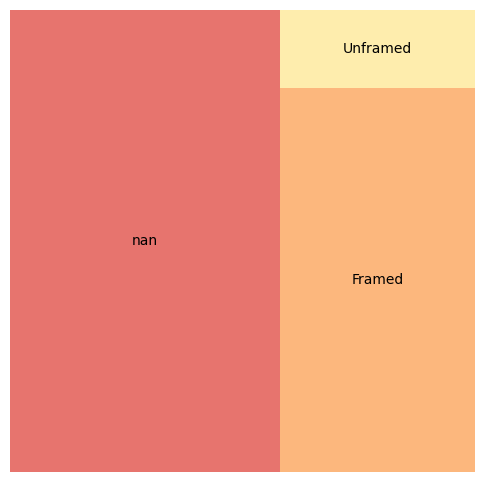

In [114]:
# Count the occurrences of each value, including blanks and null values
df_frame_counts = df_retail['Frame'].value_counts(dropna=False).reset_index()
df_frame_counts.columns = ['Frame', 'Count']

# Include blanks and null values in the count totals
total_count = df['Frame'].count() + df['Frame'].isna().sum() + (df['Frame'] == '').sum()

# Display the DataFrame with the counts and the total count
print(df_frame_counts)
print(f"Total count including blanks or null values: {total_count}")

# Then show as a treemap
# create a figure
fig, ax = plt.subplots(figsize=(6,6))
ax.set_axis_off()

# add treemap
squarify.plot(
   sizes=df_frame_counts["Count"],
   label=df_frame_counts["Frame"],
   color=sns.color_palette("Spectral"),
   alpha=0.8,
   ax=ax
)

# display plot
plt.show()


The treemap shows that a substantial quantity of the retail artwork records are missing information on framing. However, I know that in almost all cases, the more expensive artwork should be framed and the very cheapest pieces are sold without a frame.

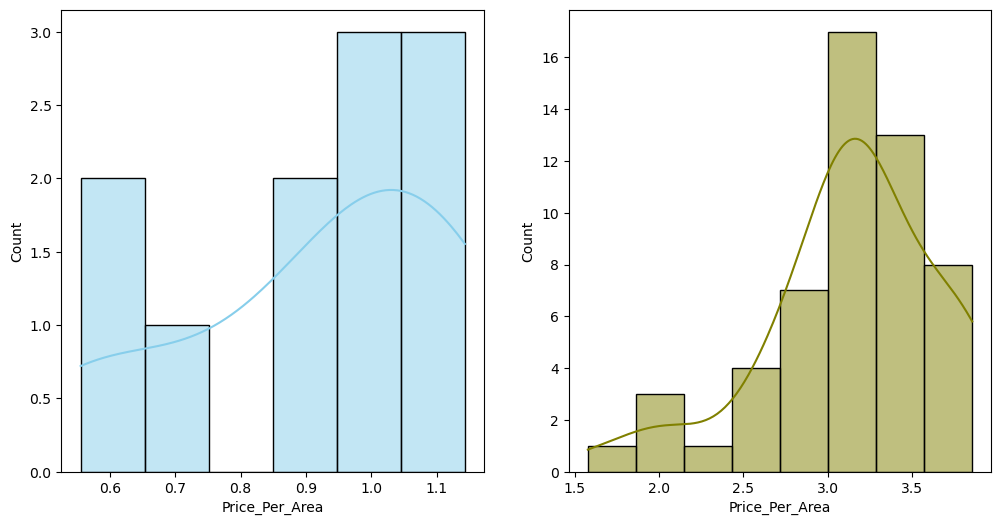

In [115]:
df_unframed = df_retail[df_retail['Frame']=='Unframed']
df_framed = df_retail[df_retail['Frame']=='Framed']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_unframed, x='Price_Per_Area', bins=6, kde=True, color='skyblue', ax=axs[0])
sns.histplot(data=df_framed, x='Price_Per_Area', bins=8, kde=True, color='olive', ax=axs[1])

plt.show()


Even though the data on framing is not complete, the data supports the hypothesis that the camel humps in the price per area distribution are a result of selling framed and unframed pieces.

## Are Commissions Delivered on Time?
Commissions are painted to order. Every customer is quoted a delivery date. Am I meeting expectations?

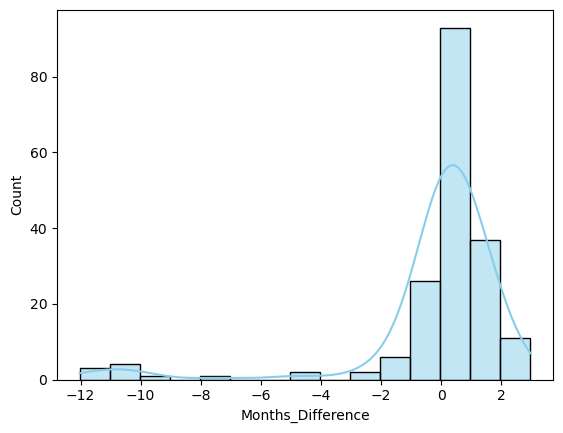

In [116]:
# keep commissions and filter out everything else
#df_commission = df[df['ServiceType']=='Commission']

# drop any commission records with missing dates
df_commission.dropna(subset=['PromisedBy', 'OrderCompletionDate'])

# Define the two dates
pd.to_datetime(df_commission['PromisedBy'])
pd.to_datetime(df_commission['OrderCompletionDate'])

# Calculate the difference in days
df_commission.loc[:,['Months_Difference']] = (df_commission['PromisedBy'] - df_commission['OrderCompletionDate']).dt.days/31

sns.histplot(data=df_commission, x='Months_Difference', bins=15, kde=True, color='skyblue')

plt.show()


The majority of my commissioned work is delivered on time, or even ahead of schedule. There are a few cases where delivery has taken longer than expected, however, it is often the case that this is done at the request of the client.

## Simple Linear Regression
### Given the Canvas Area, Can We Predict Price and Time Needed to Complete?
This regression analysis is being limited to commissioned work only.

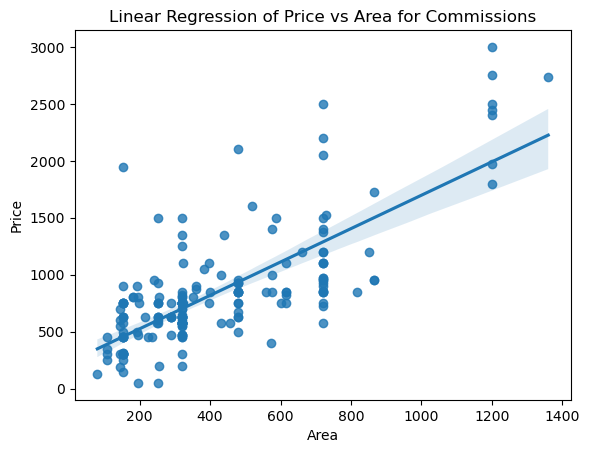

In [117]:
sns.regplot(
    x='Area',
    y='Price',
    data=df_commission
)
plt.title('Linear Regression of Price vs Area for Commissions')
plt.show()

In [118]:
# Fit linear regression to predict price using area for commissioned portraits 
x=df_commission[['Area']]
y=df_commission['Price']
lre=LinearRegression()
lre.fit(x,y)
print('The R2 value is: ', lre.score(x,y))

The R2 value is:  0.5621000285456136


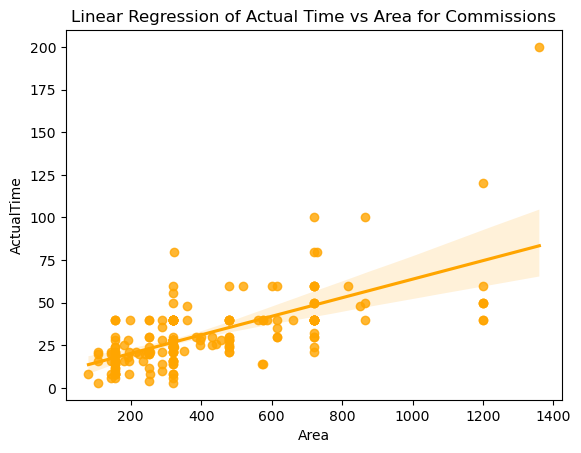

In [119]:
sns.regplot(
    x='Area',
    y='ActualTime',
    data=df_commission,
    color='orange'
)
plt.title('Linear Regression of Actual Time vs Area for Commissions')
plt.show()

In [120]:
# Fit linear regression to predict time using area for commissioned portraits 
x=df_commission[['Area']]
y=df_commission['Price']
lre=LinearRegression()
lre.fit(x,y)
print('The R2 value is: ', lre.score(x,y))

The R2 value is:  0.5621000285456136


The correlations between price, actual time and area appear to be weaker than I expected. In the next analysis we will explore regression further and introduce more features.